In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
import matplotlib
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

# Define learning parameters

In [2]:
# learning parameters
batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Prepare training dataset

In [3]:
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders
!mkdir -p input
!mkdir -p outputs

# Load train data
train_data = datasets.MNIST(
    root='input/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

A subdirectory or file -p already exists.
Error occurred while processing: -p.


100%|██████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 11115275.87it/s]


Extracting input/data\MNIST\raw\train-images-idx3-ubyte.gz to input/data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 1041615.31it/s]

Extracting input/data\MNIST\raw\train-labels-idx1-ubyte.gz to input/data\MNIST\raw



100%|███████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 4535730.52it/s]


Extracting input/data\MNIST\raw\t10k-images-idx3-ubyte.gz to input/data\MNIST\raw



100%|██████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<?, ?it/s]

Extracting input/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to input/data\MNIST\raw


# Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

# Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [6]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

# Tools for training

In [7]:
# optimizers
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [8]:
# loss function
criterion = nn.BCELoss() # Binary Cross Entropy loss

In [9]:
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [10]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)
# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)


In [11]:
# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

In [12]:
# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

In [13]:
# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

# Q. Write training loop

118it [02:16,  1.16s/it]                                                                                               


Epoch 1 of 100
Generator loss: 1.90384589, Discriminator loss: 0.80441829


118it [02:09,  1.10s/it]                                                                                               


Epoch 2 of 100
Generator loss: 1.82911179, Discriminator loss: 0.85140182


118it [01:48,  1.08it/s]                                                                                               


Epoch 3 of 100
Generator loss: 1.84361276, Discriminator loss: 0.83375461


118it [01:47,  1.10it/s]                                                                                               


Epoch 4 of 100
Generator loss: 1.87916876, Discriminator loss: 0.81552580


118it [01:55,  1.02it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


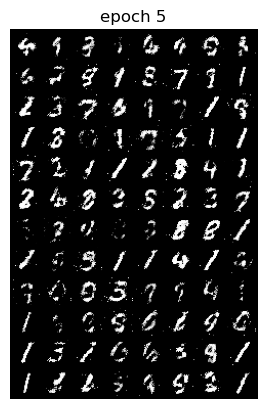

Epoch 5 of 100
Generator loss: 1.90793202, Discriminator loss: 0.80960681


118it [01:53,  1.04it/s]                                                                                               


Epoch 6 of 100
Generator loss: 1.88761828, Discriminator loss: 0.83416424


118it [02:10,  1.11s/it]                                                                                               


Epoch 7 of 100
Generator loss: 1.82465359, Discriminator loss: 0.84080908


118it [02:02,  1.04s/it]                                                                                               


Epoch 8 of 100
Generator loss: 1.93120353, Discriminator loss: 0.81160279


118it [01:40,  1.17it/s]                                                                                               


Epoch 9 of 100
Generator loss: 1.87811577, Discriminator loss: 0.82376496


118it [02:03,  1.05s/it]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


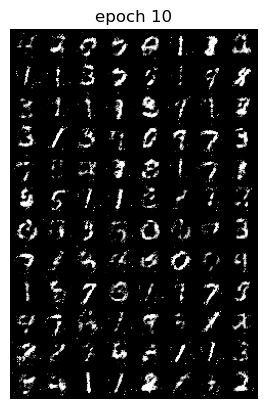

Epoch 10 of 100
Generator loss: 1.90211018, Discriminator loss: 0.83120912


118it [01:37,  1.22it/s]                                                                                               


Epoch 11 of 100
Generator loss: 1.80529998, Discriminator loss: 0.83969951


118it [02:19,  1.18s/it]                                                                                               


Epoch 12 of 100
Generator loss: 1.84018478, Discriminator loss: 0.81214391


118it [01:27,  1.35it/s]                                                                                               


Epoch 13 of 100
Generator loss: 1.83369627, Discriminator loss: 0.85989127


118it [02:09,  1.10s/it]                                                                                               


Epoch 14 of 100
Generator loss: 1.86150377, Discriminator loss: 0.86044476


118it [01:22,  1.43it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


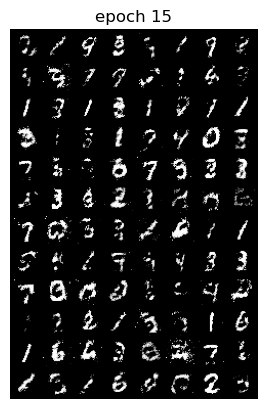

Epoch 15 of 100
Generator loss: 1.61710863, Discriminator loss: 0.93074795


118it [01:56,  1.01it/s]                                                                                               


Epoch 16 of 100
Generator loss: 1.69883625, Discriminator loss: 0.87410830


118it [01:52,  1.05it/s]                                                                                               


Epoch 17 of 100
Generator loss: 1.78458099, Discriminator loss: 0.86716850


118it [01:31,  1.29it/s]                                                                                               


Epoch 18 of 100
Generator loss: 1.70545502, Discriminator loss: 0.88529040


118it [01:40,  1.17it/s]                                                                                               


Epoch 19 of 100
Generator loss: 1.77464485, Discriminator loss: 0.85857250


118it [01:45,  1.12it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


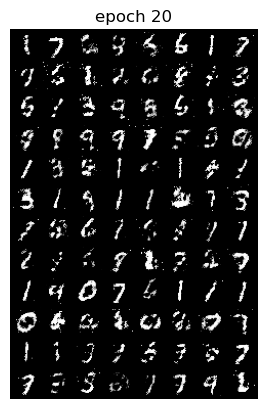

Epoch 20 of 100
Generator loss: 1.75614753, Discriminator loss: 0.86758914


118it [01:44,  1.13it/s]                                                                                               


Epoch 21 of 100
Generator loss: 1.75123828, Discriminator loss: 0.91392357


118it [01:43,  1.15it/s]                                                                                               


Epoch 22 of 100
Generator loss: 1.67234976, Discriminator loss: 0.90687110


118it [01:46,  1.11it/s]                                                                                               


Epoch 23 of 100
Generator loss: 1.64289799, Discriminator loss: 0.92099423


118it [01:28,  1.34it/s]                                                                                               


Epoch 24 of 100
Generator loss: 1.70759253, Discriminator loss: 0.88606656


118it [01:59,  1.02s/it]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


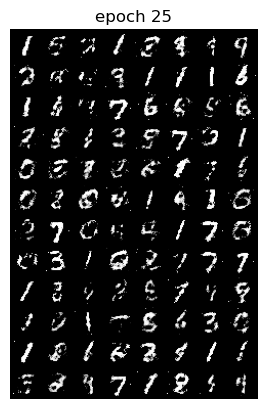

Epoch 25 of 100
Generator loss: 1.67755745, Discriminator loss: 0.86939280


118it [02:26,  1.24s/it]                                                                                               


Epoch 26 of 100
Generator loss: 1.69915410, Discriminator loss: 0.87440148


118it [02:02,  1.03s/it]                                                                                               


Epoch 27 of 100
Generator loss: 1.73804519, Discriminator loss: 0.85829175


118it [02:15,  1.15s/it]                                                                                               


Epoch 28 of 100
Generator loss: 1.68142064, Discriminator loss: 0.89509376


118it [02:18,  1.17s/it]                                                                                               


Epoch 29 of 100
Generator loss: 1.63899069, Discriminator loss: 0.90024764


118it [01:31,  1.28it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


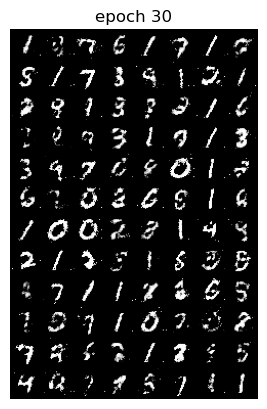

Epoch 30 of 100
Generator loss: 1.65539787, Discriminator loss: 0.94340759


118it [01:52,  1.05it/s]                                                                                               


Epoch 31 of 100
Generator loss: 1.58888536, Discriminator loss: 0.92041484


118it [01:39,  1.19it/s]                                                                                               


Epoch 32 of 100
Generator loss: 1.54323078, Discriminator loss: 0.94003737


118it [01:46,  1.11it/s]                                                                                               


Epoch 33 of 100
Generator loss: 1.59280228, Discriminator loss: 0.94710422


118it [01:25,  1.38it/s]                                                                                               


Epoch 34 of 100
Generator loss: 1.51386372, Discriminator loss: 0.96118894


118it [01:44,  1.12it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


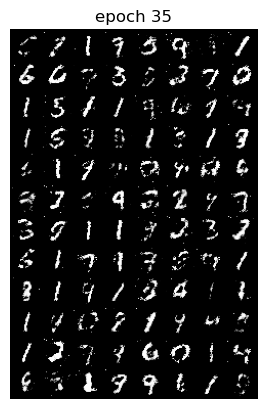

Epoch 35 of 100
Generator loss: 1.64629682, Discriminator loss: 0.92228727


118it [01:42,  1.15it/s]                                                                                               


Epoch 36 of 100
Generator loss: 1.59153359, Discriminator loss: 0.93551511


118it [01:30,  1.31it/s]                                                                                               


Epoch 37 of 100
Generator loss: 1.65768088, Discriminator loss: 0.92437284


118it [01:49,  1.08it/s]                                                                                               


Epoch 38 of 100
Generator loss: 1.56444094, Discriminator loss: 0.95288931


118it [02:03,  1.04s/it]                                                                                               


Epoch 39 of 100
Generator loss: 1.58773636, Discriminator loss: 0.92430660


118it [02:18,  1.17s/it]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


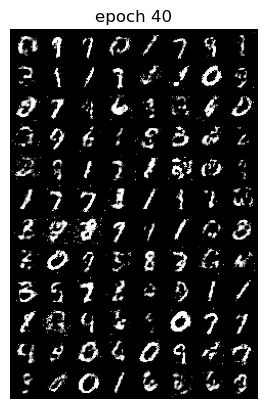

Epoch 40 of 100
Generator loss: 1.58440608, Discriminator loss: 0.95893913


118it [02:11,  1.12s/it]                                                                                               


Epoch 41 of 100
Generator loss: 1.54430187, Discriminator loss: 0.95001746


118it [02:08,  1.09s/it]                                                                                               


Epoch 42 of 100
Generator loss: 1.63451188, Discriminator loss: 0.91747269


118it [02:13,  1.13s/it]                                                                                               


Epoch 43 of 100
Generator loss: 1.56003541, Discriminator loss: 0.93964092


118it [02:16,  1.16s/it]                                                                                               


Epoch 44 of 100
Generator loss: 1.59810072, Discriminator loss: 0.94040057


118it [02:15,  1.14s/it]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


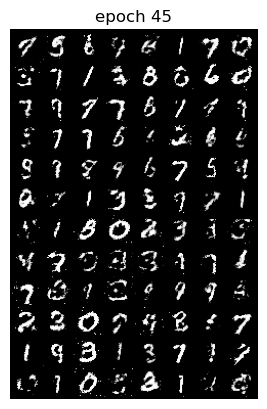

Epoch 45 of 100
Generator loss: 1.52570844, Discriminator loss: 0.97406916


118it [02:23,  1.22s/it]                                                                                               


Epoch 46 of 100
Generator loss: 1.59791585, Discriminator loss: 0.94242039


118it [02:25,  1.23s/it]                                                                                               


Epoch 47 of 100
Generator loss: 1.55174614, Discriminator loss: 0.96286580


118it [02:07,  1.08s/it]                                                                                               


Epoch 48 of 100
Generator loss: 1.52060567, Discriminator loss: 0.98553580


118it [02:19,  1.19s/it]                                                                                               


Epoch 49 of 100
Generator loss: 1.55950508, Discriminator loss: 0.94791852


118it [02:27,  1.25s/it]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


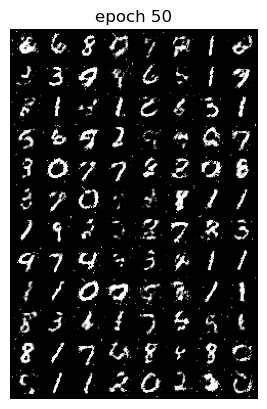

Epoch 50 of 100
Generator loss: 1.58145185, Discriminator loss: 0.96166852


118it [02:22,  1.21s/it]                                                                                               


Epoch 51 of 100
Generator loss: 1.56414130, Discriminator loss: 0.95834911


118it [02:21,  1.20s/it]                                                                                               


Epoch 52 of 100
Generator loss: 1.56927336, Discriminator loss: 0.95302886


118it [01:57,  1.00it/s]                                                                                               


Epoch 53 of 100
Generator loss: 1.51065779, Discriminator loss: 0.97526465


118it [02:06,  1.07s/it]                                                                                               


Epoch 54 of 100
Generator loss: 1.53947054, Discriminator loss: 0.96736545


118it [02:01,  1.03s/it]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


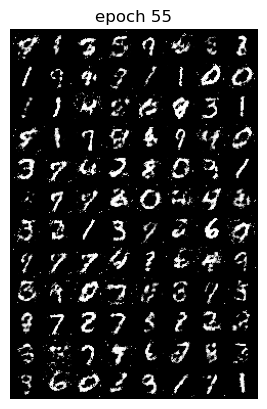

Epoch 55 of 100
Generator loss: 1.53795586, Discriminator loss: 0.95806910


118it [02:00,  1.02s/it]                                                                                               


Epoch 56 of 100
Generator loss: 1.55687217, Discriminator loss: 0.95538275


118it [01:07,  1.74it/s]                                                                                               


Epoch 57 of 100
Generator loss: 1.51136625, Discriminator loss: 0.97069802


118it [01:15,  1.56it/s]                                                                                               


Epoch 58 of 100
Generator loss: 1.50046421, Discriminator loss: 0.97699764


118it [01:04,  1.83it/s]                                                                                               


Epoch 59 of 100
Generator loss: 1.47441616, Discriminator loss: 0.98996524


118it [01:05,  1.81it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


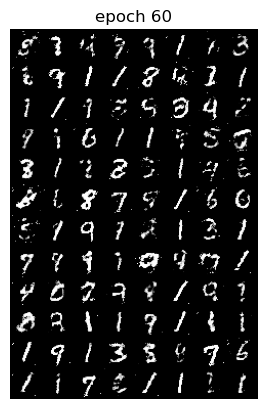

Epoch 60 of 100
Generator loss: 1.42276502, Discriminator loss: 0.98343923


118it [01:08,  1.72it/s]                                                                                               


Epoch 61 of 100
Generator loss: 1.49947068, Discriminator loss: 0.96950313


118it [01:10,  1.67it/s]                                                                                               


Epoch 62 of 100
Generator loss: 1.44620356, Discriminator loss: 0.99020404


118it [01:10,  1.67it/s]                                                                                               


Epoch 63 of 100
Generator loss: 1.49026254, Discriminator loss: 0.98951044


118it [01:08,  1.73it/s]                                                                                               


Epoch 64 of 100
Generator loss: 1.42293557, Discriminator loss: 1.00029656


118it [01:13,  1.61it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


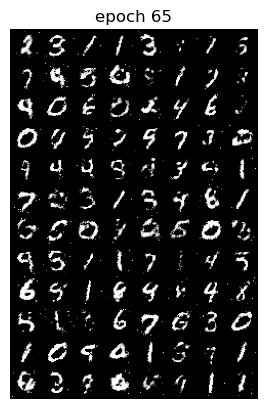

Epoch 65 of 100
Generator loss: 1.42453995, Discriminator loss: 1.00763857


118it [01:06,  1.77it/s]                                                                                               


Epoch 66 of 100
Generator loss: 1.41078189, Discriminator loss: 1.01443463


118it [01:08,  1.72it/s]                                                                                               


Epoch 67 of 100
Generator loss: 1.37304710, Discriminator loss: 1.02755511


118it [01:07,  1.75it/s]                                                                                               


Epoch 68 of 100
Generator loss: 1.42808121, Discriminator loss: 1.01595711


118it [01:12,  1.63it/s]                                                                                               


Epoch 69 of 100
Generator loss: 1.35995386, Discriminator loss: 1.02956022


118it [01:11,  1.65it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


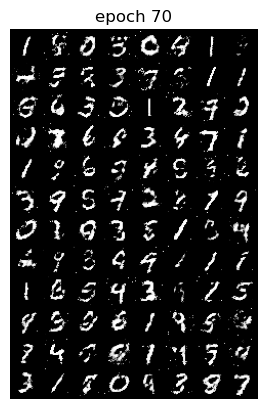

Epoch 70 of 100
Generator loss: 1.40245879, Discriminator loss: 1.02310450


118it [01:16,  1.53it/s]                                                                                               


Epoch 71 of 100
Generator loss: 1.40741917, Discriminator loss: 1.02432549


118it [01:10,  1.68it/s]                                                                                               


Epoch 72 of 100
Generator loss: 1.35128417, Discriminator loss: 1.04247177


118it [01:09,  1.70it/s]                                                                                               


Epoch 73 of 100
Generator loss: 1.33685269, Discriminator loss: 1.04822465


118it [01:23,  1.42it/s]                                                                                               


Epoch 74 of 100
Generator loss: 1.41152958, Discriminator loss: 1.02056188


118it [01:52,  1.05it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


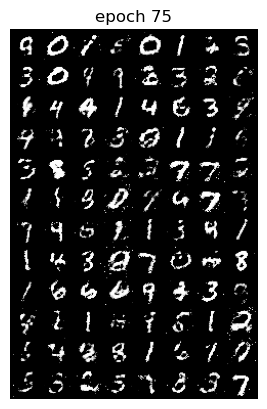

Epoch 75 of 100
Generator loss: 1.37302744, Discriminator loss: 1.02659130


118it [01:42,  1.15it/s]                                                                                               


Epoch 76 of 100
Generator loss: 1.36281993, Discriminator loss: 1.04474969


118it [01:29,  1.32it/s]                                                                                               


Epoch 77 of 100
Generator loss: 1.37242176, Discriminator loss: 1.04092229


118it [01:08,  1.72it/s]                                                                                               


Epoch 78 of 100
Generator loss: 1.35289756, Discriminator loss: 1.04840141


118it [01:30,  1.31it/s]                                                                                               


Epoch 79 of 100
Generator loss: 1.33466817, Discriminator loss: 1.04765630


118it [01:15,  1.56it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


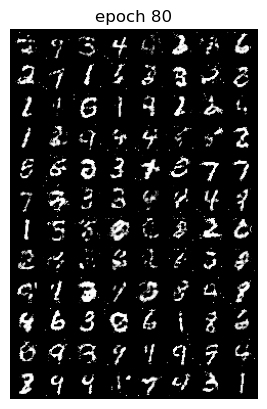

Epoch 80 of 100
Generator loss: 1.29449471, Discriminator loss: 1.05934000


118it [01:12,  1.62it/s]                                                                                               


Epoch 81 of 100
Generator loss: 1.31172603, Discriminator loss: 1.04880343


118it [01:06,  1.76it/s]                                                                                               


Epoch 82 of 100
Generator loss: 1.33323851, Discriminator loss: 1.07414147


118it [01:08,  1.73it/s]                                                                                               


Epoch 83 of 100
Generator loss: 1.30700573, Discriminator loss: 1.05875067


118it [01:10,  1.68it/s]                                                                                               


Epoch 84 of 100
Generator loss: 1.26980028, Discriminator loss: 1.07992788


118it [01:14,  1.59it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


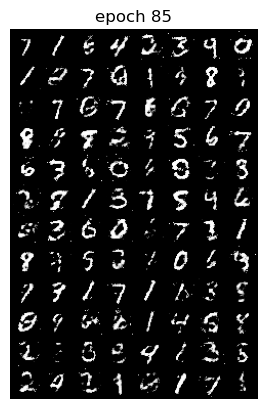

Epoch 85 of 100
Generator loss: 1.30914792, Discriminator loss: 1.04436525


118it [01:38,  1.20it/s]                                                                                               


Epoch 86 of 100
Generator loss: 1.30208846, Discriminator loss: 1.05952180


118it [01:16,  1.55it/s]                                                                                               


Epoch 87 of 100
Generator loss: 1.32601356, Discriminator loss: 1.06515788


118it [01:07,  1.75it/s]                                                                                               


Epoch 88 of 100
Generator loss: 1.30614187, Discriminator loss: 1.08324034


118it [01:23,  1.42it/s]                                                                                               


Epoch 89 of 100
Generator loss: 1.31520491, Discriminator loss: 1.06880117


118it [01:18,  1.50it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


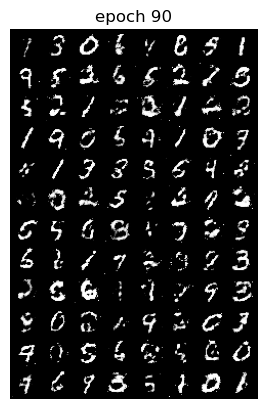

Epoch 90 of 100
Generator loss: 1.30828988, Discriminator loss: 1.08277157


118it [01:03,  1.86it/s]                                                                                               


Epoch 91 of 100
Generator loss: 1.31635898, Discriminator loss: 1.07280234


118it [01:13,  1.61it/s]                                                                                               


Epoch 92 of 100
Generator loss: 1.26413158, Discriminator loss: 1.09373236


118it [01:05,  1.81it/s]                                                                                               


Epoch 93 of 100
Generator loss: 1.27136693, Discriminator loss: 1.08056235


118it [01:00,  1.94it/s]                                                                                               


Epoch 94 of 100
Generator loss: 1.36729013, Discriminator loss: 1.05317330


118it [01:08,  1.73it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


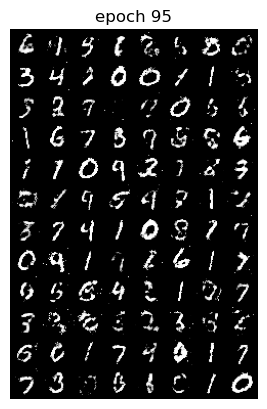

Epoch 95 of 100
Generator loss: 1.24880800, Discriminator loss: 1.07843718


118it [01:01,  1.91it/s]                                                                                               


Epoch 96 of 100
Generator loss: 1.26678604, Discriminator loss: 1.08683528


118it [01:03,  1.85it/s]                                                                                               


Epoch 97 of 100
Generator loss: 1.26909658, Discriminator loss: 1.09973383


118it [01:05,  1.80it/s]                                                                                               


Epoch 98 of 100
Generator loss: 1.22640601, Discriminator loss: 1.09998062


118it [01:01,  1.91it/s]                                                                                               


Epoch 99 of 100
Generator loss: 1.27557546, Discriminator loss: 1.07820506


118it [01:04,  1.84it/s]                                                                                               
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


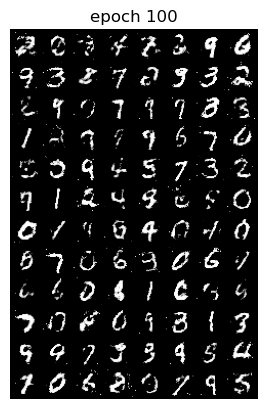

Epoch 100 of 100
Generator loss: 1.26350440, Discriminator loss: 1.09514840


In [19]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    return criterion(output.view(-1, 1), true_label)
    
def discriminator_loss(output, true_label):
     return criterion(output.view(-1, 1), true_label)
    
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data)/train_loader.batch_size)):
        ############ YOUR CODE HERE ########## 
        image, _ = data
        image = image.to(device)
        
        real_label = label_real(len(image))
        fake_label = label_fake(len(image))
        
        discriminator.zero_grad()
        output = discriminator(image).view(-1)
        loss_d_real = discriminator_loss(output, real_label)
        loss_d_real.backward()
        
        noise = create_noise(len(image), nz)
        fake_data = generator(noise)
        output = discriminator(fake_data.detach()).view(-1)
        loss_d_fake = discriminator_loss(output, fake_label)
        loss_d_fake.backward()
        
        optim_d.step()
        loss_d += loss_d_real.item() + loss_d_fake.item()
        
        generator.zero_grad()
        output = discriminator(fake_data).view(-1)
        loss_g_real = generator_loss(output, real_label)
        loss_g_real.backward()
        
        optim_g.step()
        loss_g += loss_g_real.item()
    
        ######################################
    
    
    # create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()
    
    # make the images as grid
    generated_img = make_grid(generated_img)
    
    # visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()
    
    # save the generated torch tensor models to disk
    save_generator_image(generated_img, f"outputs/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

In [20]:
print('DONE TRAINING')
torch.save(generator.state_dict(), 'outputs/generator.pth')

DONE TRAINING


In [21]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('outputs/generator_images.gif', imgs)

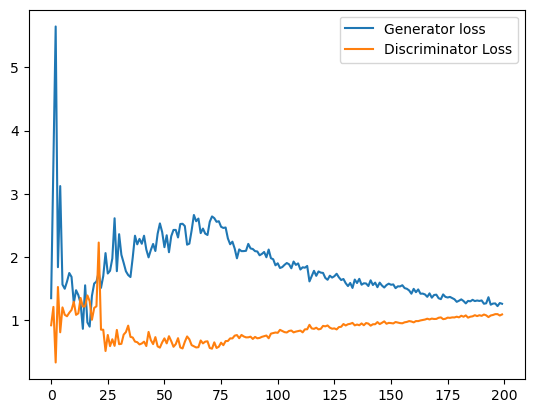

In [22]:
# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('outputs/loss.png')